In [1]:
%matplotlib inline
%load_ext nengo.ipynb
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

# Communication Channel

This example demonstrates how to create a connections from one neuronal ensemble to another that behaves like a communication channel (that is, it transmits information without changing it). 

Network diagram:

      [Input] ---> (A) ---> (B)

An abstract input signal is fed into a first neuronal ensemble $A$, which then passes it on to another ensemble $B$. The result is that spiking activity in ensemble $B$ encodes the value from the Input.  

## Step 1: Create the Network

In [2]:
import numpy as np
import nengo
from nengo.dists import Uniform
import nengo_detailed_neurons
from nengo_detailed_neurons.neurons import Bahr2, IntFire1
from nengo_detailed_neurons.synapses import ExpSyn, FixedCurrent

# Create a 'model' object to which we can add ensembles, connections, etc.  
model = nengo.Network(label="Communications Channel", seed=3145987)
with model:
    # Create an abstract input signal that oscillates as sin(t)
    sin = nengo.Node(lambda x: np.sin(x))
    
    # Create the neuronal ensembles
    num_A_neurons = 200
    num_B_neurons = 50
    A = nengo.Ensemble(num_A_neurons, dimensions=1, max_rates=Uniform(60, 80))
    B_lif = nengo.Ensemble(num_B_neurons, dimensions=1, max_rates=Uniform(60, 80))
    B_bahr2 = nengo.Ensemble(num_B_neurons, dimensions=1, neuron_type=Bahr2(), max_rates=Uniform(60, 80))
    B_ttx = nengo.Ensemble(num_B_neurons, dimensions=1, neuron_type=Bahr2(), max_rates=Uniform(60, 80))
    
    # Connect the input to the first neuronal ensemble
    nengo.Connection(sin, A)
    
    # Connect the first neuronal ensemble to the second (this is the communication channel)
    nengo.Connection(A, B_lif, synapse=0.005)
    solver = nengo.solvers.LstsqL2(True)
    nengo.Connection(A, B_bahr2, solver=solver, synapse=ExpSyn(0.005))
    nengo.Connection(A, B_ttx, solver=solver, synapse=ExpSyn(0.005))

/home/jgosmann/Documents/projects/nengo/nengo/builder/builder.py:60: UserWarning: Type '<class 'nengo.ensemble.Ensemble'>' already has a builder. Overwriting.
  % nengo_class)
/home/jgosmann/Documents/projects/nengo/nengo/builder/builder.py:60: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


## Step 2: Add Probes to Collect Data
Even this simple model involves many quantities that change over time, such as membrane potentials of individual neurons. Typically there are so many variables in a simulation that it is not practical to store them all. If we want to plot or analyze data from the simulation we have to "probe" the signals of interest. 

In [3]:
with model:
    sin_probe = nengo.Probe(sin)
    A_probe = nengo.Probe(A, synapse=.01)  # ensemble output 
    B_lif_probe = nengo.Probe(B_lif, synapse=.01)
    B_bahr2_probe = nengo.Probe(B_bahr2, synapse=.01)
    B_ttx_probe = nengo.Probe(B_ttx, synapse=.01)

## Step 3: Run the Model!  

In [4]:
sim = nengo.Simulator(model)

In [7]:
ch_reduction = 1. / (1. - .6)
for c in nengo_detailed_neurons.builder.ens_to_cells[B_ttx]:
    c.neuron.soma.gbar_nat /= ch_reduction
    c.neuron.hillock.gbar_nat /= ch_reduction
    c.neuron.tuft.gbar_nat /= ch_reduction
    c.neuron.iseg.gbar_nat /= ch_reduction
    c.neuron.recalculate_channel_densities()

In [8]:
sim.run(2 * np.pi)

## Step 4: Results

RMSE 0.100613866754


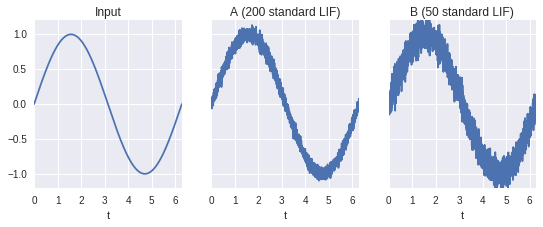

In [23]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.plot(sim.trange(), sim.data[sin_probe])
plt.xlabel("t")
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)
plt.subplot(1, 3, 2)
plt.title("A ({} standard LIF)".format(num_A_neurons))
plt.plot(sim.trange(), sim.data[A_probe])
plt.xlabel("t")
plt.gca().set_yticklabels([])
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)
plt.subplot(1,3,3)
plt.title("B ({} standard LIF)".format(num_B_neurons))
plt.plot(sim.trange(), sim.data[B_lif_probe])
plt.xlabel("t")
plt.gca().set_yticklabels([])
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)

print 'RMSE', nengo.utils.numpy.rmse(np.sin(sim.trange()), np.squeeze(sim.data[B_lif_probe]))

RMSE 0.212640707621


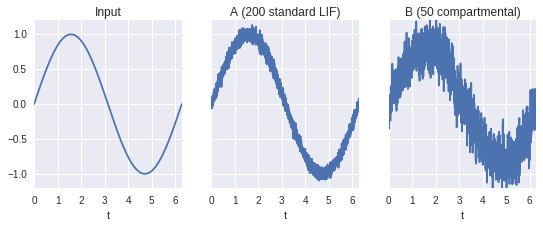

In [24]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.plot(sim.trange(), sim.data[sin_probe])
plt.xlabel("t")
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)
plt.subplot(1, 3, 2)
plt.title("A ({} standard LIF)".format(num_A_neurons))
plt.plot(sim.trange(), sim.data[A_probe])
plt.xlabel("t")
plt.gca().set_yticklabels([])
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)
plt.subplot(1,3,3)
plt.title("B ({} compartmental)".format(num_B_neurons))
plt.plot(sim.trange(), sim.data[B_bahr2_probe])
plt.xlabel("t")
plt.gca().set_yticklabels([])
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)

print 'RMSE', nengo.utils.numpy.rmse(np.sin(sim.trange()), np.squeeze(sim.data[B_bahr2_probe]))

RMSE 0.683588327864


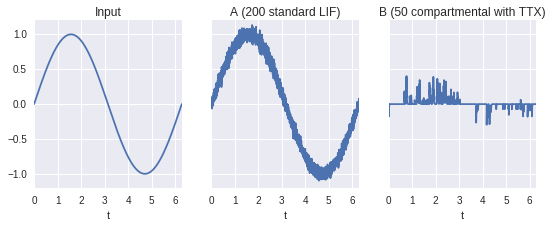

In [25]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.plot(sim.trange(), sim.data[sin_probe])
plt.xlabel("t")
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)
plt.subplot(1, 3, 2)
plt.title("A ({} standard LIF)".format(num_A_neurons))
plt.plot(sim.trange(), sim.data[A_probe])
plt.xlabel("t")
plt.gca().set_yticklabels([])
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)
plt.subplot(1,3,3)
plt.title("B ({} compartmental with TTX)".format(num_B_neurons))
plt.plot(sim.trange(), sim.data[B_ttx_probe])
plt.xlabel("t")
plt.gca().set_yticklabels([])
plt.xlim(0, 2 * np.pi)
plt.ylim(-1.2, 1.2)
plt.savefig('ttx.png')

print 'RMSE', nengo.utils.numpy.rmse(np.sin(sim.trange()), np.squeeze(sim.data[B_ttx_probe]))